# Сборный проект № 2

## Описание проекта
В нашем распоряжении данные стартапа, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения. 

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.


## Структура данных
Каждая запись в логе `/datasets/logs_exp.csv` - это действие пользователя, или событие. 

`EventName` — название события; 

`DeviceIDHash` — уникальный идентификатор пользователя;

`EventTimestamp` — время события;

`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка данных

#### 1. Загружаем библиотеки и изучаем данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#следующие библиотеки понадобятся для проверки гипотез и анализа A/B-тестов
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
from datetime import datetime
from scipy.stats import norm
#документирую plotly из-за ограничений GitHub - ниже график в png.
from plotly import graph_objects as go
import plotly.express as px
!pip install -U kaleido

In [2]:
logs = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
#server_path = '/datasets/logs_exp.csv'
#filename = 'logs_exp.csv'

#try:
    #logs = pd.read_csv(filename) 
#except: 
    #logs = pd.read_csv(server_path)

In [4]:
#изучим данные
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
#выводим первые 5 строчек датасета на экран
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
#выводим количество пропущенных значений для каждого столбца
logs.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [7]:
#проверяем датасет на скрытые дубликаты 
logs.duplicated().sum()

413

In [8]:
#посчитаем процент дубликатов от общего количества значений
print(f'{(logs.duplicated().sum()/len(logs)):.3%} - процент дубликатов от общего количества значений датасета')

0.169% - процент дубликатов от общего количества значений датасета


In [9]:
#переименуем столбцы, приведем их к нижнему регистру
logs = logs.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id', 'EventTimestamp':'sec_time', 'ExpId':'group'})

In [10]:
print(logs)

                     event_name            device_id    sec_time  group
0              MainScreenAppear  4575588528974610257  1564029816    246
1              MainScreenAppear  7416695313311560658  1564053102    246
2       PaymentScreenSuccessful  3518123091307005509  1564054127    248
3              CartScreenAppear  3518123091307005509  1564054127    248
4       PaymentScreenSuccessful  6217807653094995999  1564055322    248
...                         ...                  ...         ...    ...
244121         MainScreenAppear  4599628364049201812  1565212345    247
244122         MainScreenAppear  5849806612437486590  1565212439    246
244123         MainScreenAppear  5746969938801999050  1565212483    246
244124         MainScreenAppear  5746969938801999050  1565212498    246
244125       OffersScreenAppear  5746969938801999050  1565212517    246

[244126 rows x 4 columns]


In [11]:
#создаем столбец даты и времени (в столбце EventTimestamp изначально значения были в секундах, перевели их в даты)
logs['datetime'] = pd.to_datetime(logs['sec_time'], unit='s')

In [12]:
#создаем столбец даты
logs['dt'] = pd.to_datetime(logs['datetime']).dt.date

In [13]:
#поскольку полные дубликаты составляют несущественную часть датасета, удалим их на данном этапе
logs = logs.drop_duplicates()

In [14]:
#повторно выведем первые 5 строк таблицы
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   sec_time    243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   datetime    243713 non-null  datetime64[ns]
 5   dt          243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


В рамках предварительного анализа мы выявили, что в датасете отсутствуют пропуски, но есть 413 полных дубликатов, поскольку их количество незначительно в разрезе всего датасета, - удалим такие дубликаты. Также мы дополнили датасет двумя новыми столбцами, переименовали столбцы и привели их к нижнему регистру.

## Исследовательский анализ данных

#### 2. Проверим, сколько всего событий в логе

In [15]:
print(f'Всего в логе после предобработки {len(logs)} событий.')

Всего в логе после предобработки 243713 событий.


#### 3. Проверим, сколько всего пользователей в логе

In [16]:
print(f'Всего пользователей в логе {len(logs.device_id.unique())}.')

Всего пользователей в логе 7551.


#### 4. Проверим, сколько в среднем событий приходится на пользователя, а также оценим минимальное, максимальное и медианное количество событий, которое совершает пользователь в приложении. 

In [17]:
#создадим отдельную переменную events_by_user, чтобы с помощью describe() оценить сразу все значения
events_by_user = logs.groupby('device_id').agg(count = ('event_name', 'count')).reset_index()

display(events_by_user['count'].describe())

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: count, dtype: float64

В среднем на каждого пользователя приходится по 32 события, медиана - 20 событий, минимальное количество событий - 1, а максимальное целых 2307.

#### 5. Проверим, данными за какой период мы располагаем. Найдем максимальную и минимальную дату. Построем гистограмму по дате и времени. 

In [18]:
#находим максимальную и минимальную дату в датасете по столбцу dt
logs.agg({'dt': ['min', 'max']})

,dt
min,2019-07-25
max,2019-08-07


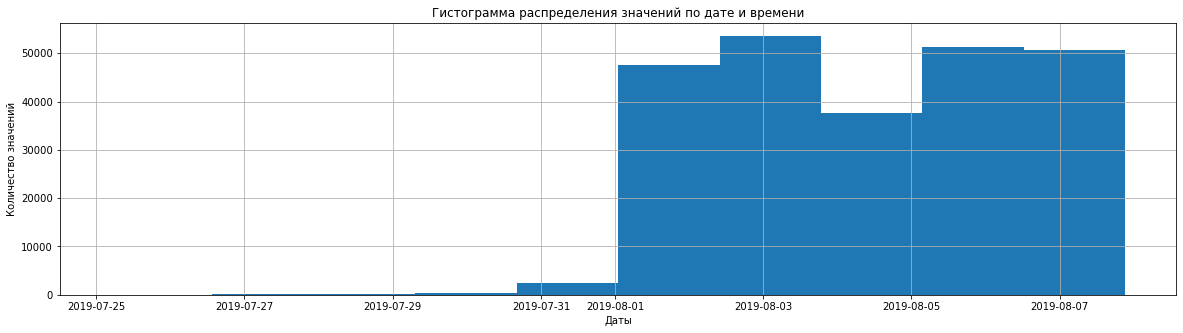

In [19]:
#строим гистограмму по дате и времени
logs['datetime'].hist(figsize=(20,5))
plt.ylabel('Количество значений')
plt.xlabel('Даты')
plt.title('Гистограмма распределения значений по дате и времени')
plt.show()

Мы обладаем данными за период с "25" июля 2019 года по "07" августа 2019 года. На построенной гистограмме видим резкий скачок значений с "01" августа 2019 года, - вероятно, увеличению количества логов способствовала распродажа продуктов питания, либо какая-то маркетинговая акция, и пользователи активно совершали действия в приложении. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные», что и произошло в нашем случае. Исходя из графика делаем вывод, что данные полные с 01.08.2019, старые данные отбросим ниже.

In [20]:
#создаем переменную logs_clear, чтобы посчитать много ли событий и пользователей мы потеряли, отбросив старые данные
logs_clear = logs.query('dt >= datetime(2019, 8, 1).date()')

In [21]:
print(f'{(len(logs_clear) / len(logs)):.2%} - доля событий оставшихся данных')
print(f'Всего пользователей в оставшихся данных {len(logs_clear.device_id.unique())}.')
#проверяем, что у нас есть пользователи из всех трёх экспериментальных групп
print(logs_clear.groupby('group')['device_id'].nunique())

98.84% - доля событий оставшихся данных
Всего пользователей в оставшихся данных 7534.
group
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


In [22]:
print('Относительные потери событий после фильтрации:', 
      len(logs_clear) - len(logs), 
      '({:.1%})'.format((len(logs_clear) - len(logs))/len(logs)))
print(
    'Относительные потери уникальных пользователей:', 
      logs_clear['device_id'].nunique() - logs['device_id'].nunique(), 
      '({:.1%})'.format((logs['device_id'].nunique()-logs_clear['device_id'].nunique())/logs['device_id'].nunique())
)

Относительные потери событий после фильтрации: -2826 (-1.2%)
Относительные потери уникальных пользователей: -17 (0.2%)


По результатам фильтрации мы теряем 1.2% событий и 0.2% уникальных пользователей.

In [23]:
#перезапишем logs
logs = logs_clear

Отбросив логи, записанные в период с "25" июля по "31" августа мы потеряли менее 2% данных датасета. Всего пользователей в оставшихся данных - 7534, при чем что в изначальном датасете пользователей насчитывалось 7551. Каждая из трех групп попадает в очищенный нами датасет. 

### Изучение воронки событий

#### 6. Изучаем события в логах

In [24]:
#посмотрим, какие события есть в логах
logs['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

Итого у нас есть 5 различных событий:
- Tutorial (прохождение обучения),
- MainScreenAppear (просмотр главной страницы),
- OffersScreenAppear (показ товара),
- CartScreenAppear (просмотр корзины),
- PaymentScreenSuccessful (показ уведомления об успешной оплате)

#### 7. Посмотрим частоту событий в логах

In [25]:
#частота событий в логе
print(logs.groupby('event_name').count().sort_values(by='device_id', ascending=False))

                         device_id  sec_time   group  datetime      dt
event_name                                                            
MainScreenAppear            117328    117328  117328    117328  117328
OffersScreenAppear           46333     46333   46333     46333   46333
CartScreenAppear             42303     42303   42303     42303   42303
PaymentScreenSuccessful      33918     33918   33918     33918   33918
Tutorial                      1005      1005    1005      1005    1005


Больше всего в логах события "просмотр главной страницы", затем в 2 раза меньше "показ товара", чуть меньше "просмотр корзины", и еще меньше "показ уведомления об успешной оплате". 

In [26]:
#посчитаем, сколько пользователей совершали каждое из вышеуказанных событий, отсортируем события по числу пользователей 
#считаем долю пользователей, которые хоть раз совершали событие
funnel = (logs_clear.
          groupby('event_name').
          agg({'device_id': 'nunique'}).
          reset_index().
          rename(columns={'device_id' : 'total_users'}).
          sort_values(by='total_users', ascending=False))
funnel['percent'] = round(funnel['total_users'] / logs['device_id'].nunique() * 100, 2)
#используем метод shift() для получения предыдущего значения столбца при оценке конверсии n/n-1
percent_initial = funnel['total_users'].shift()
#рассчитаем конверсию n/n-1
conversion = funnel['total_users']/percent_initial
#рассчитаем конверсию из первого шага n/first, используя метод max()
conversion_first_step = funnel['total_users']/funnel['total_users'].max()

В наших логах мы видим, что обучение проходит всего 11% пользователей, значит - обучение не является обязательным. Также исходя из цифр выше видим, что пользователь не проходит все этапы последовательно, ведь тогда первое событие было бы 100%. 

Для последующего построения воронки событий не будем учитывать событие 'Tutorial', т.к. оно не является обязательным для совершения оплаты, и помешает нам понять, на каком этапе мы теряем больше всего пользователей. 

Просмотр главного экрана - событие `MainScreenAppear` может быть не у всех пользователей, т.к. пользователь может приходить в приложение органически по ссылке и попадать сразу на страницу товара, затем положить его в корзину и совершить покупку, в таком случае для совершения покупки ему не требуется просматривать главный экран. 

In [27]:
#исключаем из ранее созданной нами таблицы событие 'Tutorial'
funnel = funnel.query('event_name != "Tutorial"')

#### 8. По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [28]:
fig = go.Figure(go.Funnel(y = funnel['event_name'],
                          x = funnel['total_users'],
                          textinfo = 'value+percent initial+percent previous'))
fig.update_layout(title_text='Воронка событий по количеству пользователей, проходящих на следующий шаг воронки')
fig.update_layout(yaxis_title='События воронки')
fig.write_image("C:/Users/Мария/Pictures/fig1.png")

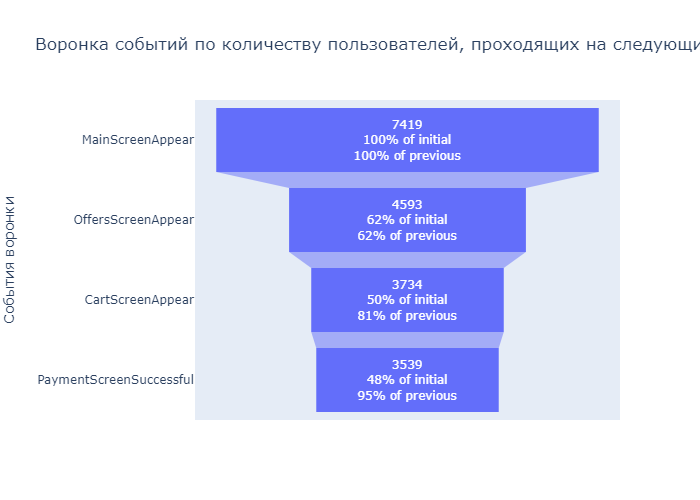

In [29]:
from IPython.display import Image
image_path = "C:/Users/Мария/Pictures/fig1.png"
Image(filename=image_path)

Исходя из воронки видим, что больше всего пользователей теряется на этапе показа карточки (после первого шага теряем 38% пользователей). О чем это может говорить? Например, пользователям не нравится интерфейс и они покидают мобильное приложение, не дойдя даже до просмотра карточки товара. Также пользователь может выполнять действия непоследовательно, - минуя просмотр карточки сразу производить оплату, т.к. они заказывают товар постоянно и знают его качества.

Из 7534 пользователей дошло до покупки 3539, т.е. 46% пользователей - очень хороший результат! 

### Изучение результатов эксперимента

Пользователей разбили на 3 группы: 2 контрольные (246 и 247) со старыми шрифтами и одну (248) экспериментальную — с новыми. 
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. 

#### 10. Изучение количества пользователей в каждой экспериментальной группе

In [30]:
logs.groupby('group')['device_id'].nunique()

group
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

В экспериментальной группе 246 - 2483 пользователя, в группе 247 - 2512 пользователя, в группе 248 - 2535 пользователей.

In [31]:
#проверяем наличие пользователей, которые попадают в обе группы, а именно в 246 и 247
cross_users = logs.groupby('device_id').agg({'group': pd.Series.nunique}).query('group > 1')
print(cross_users.count())

group    0
dtype: int64


In [32]:
#посмотрим, сколько пользователей каждой группы приходится на событие
check_log = logs.pivot_table(index='group', columns='event_name', values='device_id', aggfunc='nunique')
display(check_log)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
group,,,,,
246,1266,2450,1542,1200,278
247,1238,2476,1520,1158,283
248,1230,2493,1531,1181,279


#### 11. Подготовим функцию для проведения z-теста, с помощью которой мы будем сравнивать выборки по событиям

Функция будет использована для сравнения выборок:

1) сравнение выборок по событиям в группах 246 и 247 - 4 теста;

2) сравнение выборок по событиям в группах 246 и 248 - 4 теста;

3) сравнение выборок по событиям в группах 247 и 248 - 4 теста;

4) сравнение выборок 246 + 247 и 248 - 4 теста.

В А/В-тестировании проверяем гипотезу о равенстве выборок, но сначала проверим находят ли статистические критерии разницу между выборками 246 и 247 (А/А-тест). Используем Z-тест. 

Ниже выбран уровень статистической значимости - 0.05. Такой уровень выбран, т.к. при уровне значимости 0.1 каждый десятый раз можно получать ложный результат.

In [33]:
#создаем датафрейм с индексом названия события и колонками название группы + размер группы
group = logs.pivot_table(index='event_name', columns='group', values='device_id', aggfunc='nunique')\
             .sort_values(246, ascending=False) #создаем датафрейм с индексом названия события и колонками название группы + размер группы
#создаем датафрейм с индексом группы и размером группы
values_group = logs.pivot_table(index='group', values = 'device_id', aggfunc = 'nunique')

In [34]:
#создадим функцию,которая считает статистический тест
def calculate_stat_test(successes1, successes2, trials1, trials2, alpha=0.05):
    #входные параметры: successes1, successes2 - перешедшие на следующий уровень,
# а trials1, trials2 - количество пользователей с предыдущего уровня, alpha - уровень статистической значимости
    
    # критический уровень статистической значимости c поправкой Бонферрони (выполняем несколько тестов одновременно, 
    #хотим контролировать вероятность совершения ошибки первого рода, у нас 16 тестов, делим на 16)
    bonferroni_alpha = alpha / 16
    
    p1 = successes1/trials1 #пропорция успехов в первой группе
    p2 = successes2/trials2 #пропорция успехов во второй группе
    
    #пропорция успехов в комбинированном датасете
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    #разница пропорций в датасетах
    difference = p1 - p2

    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
 
    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    #если пропорции равны, разница между ними равна нулю, посчитаем, как далеко статистика уехала от нуля  
    #распределение статистики нормальное, вызовем метод cdf()
    #статистику возьмем по модулю abs() - чтобы правильный результат был независимо от знака
    p_value = (1 - distr.cdf(abs(z_value))) * 2
   
    print('p-значение: ', p_value)
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

При расчетах применяем поправку Бонферрони для снижения вероятность ложноположительного результата эксперимента. Поскольку у нас 16 тестов, делим alpha на 16.

Во всех последующих расчетах ниже значения p-value для событий будут идти в следующем порядке:
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful

В дальнейшем с помощью цикла и ранее написанной нами функцией выясним, есть ли статистически значимая разница между исследуемыми группами.

**Нулевая гипотеза**: статистически значимой разницы нет, нет оснований считать доли разными.

**Альтернативная гипотеза**: разница является статистически значимой, результаты в группах отличаются.


Если разницы между выборками не будет обнаружено, то считаем, что изменение шрифтов в мобильном приложении не влияет на взаимодействие пользователей с приложением.
Если будет обнаружена статистически значимая разница, то считаем, что изменение шрифтов в мобильном приложении влияет на взаимодействие пользователя с приложением.

#### 12. Через цикл рассчитаем p-значение для групп 246 и 247 

In [35]:
for i in group.index:
    successes1 = group.loc[i, 246]
    trials1 = values_group.loc[246]
    successes2 = group.loc[i, 247]
    trials2 = values_group.loc[247]
    calculate_stat_test(successes1, successes2, trials1, trials2, alpha=0.05)

p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.93769962]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистические критерии разницу между выборками 246 и 247 не находят. Также была сделана проверка через сервис: https://www.evanmiller.org/ab-testing/chi-squared.html#, который показал, что нет оснований считать доли разными (дополнительно проверили p-value, меняя значение 'confidence level', и при confidence level 95% и при 90% результат не менялся).  
А/А-тест проводится, чтобы убедиться, что результатам эксперимента по изменению шрифта можно доверять. 

#### 13. Через цикл рассчитаем p-значение для групп 247 и 248

In [36]:
for i in group.index:
    successes1 = group.loc[i, 247]
    trials1 = values_group.loc[247]
    successes2 = group.loc[i, 248]
    trials2 = values_group.loc[248]
    calculate_stat_test(successes1, successes2, trials1, trials2, alpha=0.05)

p-значение:  [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.76532392]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При заданном уровне значимости различия между группами 247 и 248 не обнаружились.

#### 14. Через цикл рассчитаем p-значение для групп 246 и 248

In [37]:
for i in group.index:
    successes1 = group.loc[i, 246]
    trials1 = values_group.loc[246]
    successes2 = group.loc[i, 248]
    trials2 = values_group.loc[248]
    calculate_stat_test(successes1, successes2, trials1, trials2, alpha=0.05)

p-значение:  [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.8264294]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистические критерии разницу между выборками 246 и 248 не находят.

#### 15. Через цикл рассчитаем p-значение для групп 246+247 и 248

In [38]:
for i in group.index:
    successes1 = group.loc[i, 246] + group.loc[i, 247]
    trials1 = values_group.loc[246] + values_group.loc[247]
    successes2 = group.loc[i, 248]
    trials2 = values_group.loc[248]
    calculate_stat_test(successes1, successes2, trials1, trials2, alpha=0.05)

p-значение:  [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.76486247]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнив группу с изменённым шрифтом с объединенной контрольной группой установили, что нет оснований считать доли разными. 

Промежуточный вывод:
1. Мы сделали 16 проверок статистических гипотез.
2. Разбиение на группы работает корректно.
3. Ни при одном расчете p-value не было обнаружено разницы между выборками, - это означает, что изменение шрифтов в мобильном приложении не влияет на взаимодействие пользователей с приложением.

### Итоговый вывод:

В ходе исследования мы изучили данные работы мобильного приложения стартапа по продаже продуктов питания. Данные были получены в ходе проведения эксперимента, в рамках которого дизайнеры поменяли штрифты во всем приложении. 

В процессе предобработки были удалены полные дубликаты, заменены названия столбцов, а также добавлены новые столбцы. По результатам предобработки имеем следующее:
- 243713 событий в логах;
- 7551 уникальный пользователь;
- в среднем на каждого пользователя приходится 32 события.

Было установлено, что в логах 5 событий: просмотр главной страницы, просмотр карточки товара, просмотр корзины, обучение и экран с уведомлением об успешной оплате. Пользователи совершают события непоследовательно, - такой вывод мы сделали из воронки на этапе 8. Было принято решение удалить событие "Tutorial" до проведения статистических тестов, т.к. событие не является обязательным и не оказывает влияние на остальные события. 
Для изучения взяли данные с "01" августа 2019 года по "07" августа 2019 года, т.к. логи за указанный промежуток времени составляют 98.84% всего датасета.
Из 7534 пользователей дошло до покупки 3539, т.е. 46% пользователей.

В датасете данные 3 экспериментальных групп:
- 246 (контрольная группа) - 2483 пользователей;
- 247 (контрольная группа) - 2512 пользователей;
- 248 (экспериментальная группа) - 2535 пользователей.

Мы провели исследование результатов A/A/B-эксперимента.
Нулевой гипотезой было предположение, что выбранный дизайнерами шрифт не влияет на взаимодействие пользователей с приложением. Альтернативная гипотеза: изменение шрифта во всем приложении влияет на взаимодействие пользователей с приложением.
Отвергнуть нулевую гипотезу не удалось, мы не обнаружили статистически значимой разницы между группами, - шрифт не влияет на взаимодействие пользователя с приложением.
